In [1]:
import sys
sys.path.insert(0, "../")
import time
import numpy as np
from pinn import *
from grad_stats import *

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import grad
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR

from tqdm import tqdm_notebook as tqdm 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/vemuri/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


seed 1


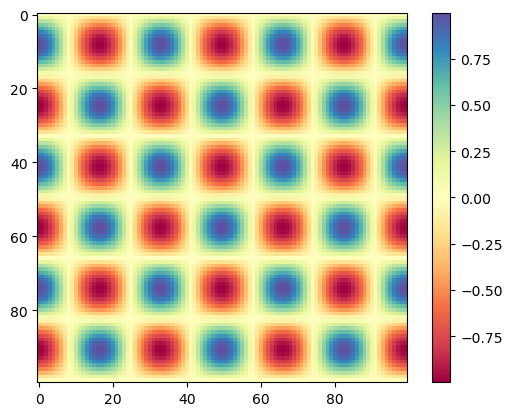

In [2]:
# experiment setup
lx=ly=0
rx=ry=1
seed   = 1
omega = 6*np.pi

print("seed", seed)

# genereate ground truth
def poisson_equation(x,y,omega):
    return np.cos(omega*x)*np.sin(omega*y)

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

xx,yy = np.meshgrid(x,y)
u_sol = poisson_equation(xx,yy,omega)

X = np.vstack([xx.ravel(), yy.ravel()]).T
plt.imshow(u_sol, cmap="Spectral")
plt.colorbar()


In [3]:
def sampler(num_r=2500, num_b=100,lx=0,rx=1,ly=0,ry=1,seed=1):
    # generate training data
    x = np.linspace(lx, rx, 100)
    y = np.linspace(ly, ry, 100)
    xb = np.linspace(lx,rx,num_b)
    yb = np.linspace(ly,ry,num_b)
    
    xx,yy = np.meshgrid(x,y)
    
    X = np.vstack([xx.ravel(), yy.ravel()]).T


    # X boundaries
    lb   = lx*np.ones((yb.shape))
    rb   = rx*np.ones((yb.shape))
    Xlb  = np.vstack((lb,yb)).T
    Xrb  = np.vstack((rb,yb)).T
    UXlb = np.cos(omega*Xlb[:,0])*np.sin(omega*Xlb[:,1])
    UXrb = np.cos(omega*Xrb[:,0])*np.sin(omega*Xrb[:,1])

    # Y boundaries
    lb   = ly*np.ones((xb.shape))
    rb   = ry*np.ones((xb.shape))
    Ylb  = np.vstack((xb,lb)).T
    Yrb  = np.vstack((xb,rb)).T
    UYlb = np.cos(omega*Ylb[:,0])*np.sin(omega*Ylb[:,1])
    UYrb = np.cos(omega*Yrb[:,0])*np.sin(omega*Yrb[:,1])

    seedc = seed
    np.random.seed(seedc)
    torch.manual_seed(seedc)

    # training tensors
    idxs = np.random.choice(xx.size, num_r, replace=False)
    X_train = torch.tensor(X[idxs], dtype=torch.float32, requires_grad=True,device=device)
    X_rb = torch.tensor(Xrb, dtype=torch.float32, device=device)
    X_lb = torch.tensor(Xlb, dtype=torch.float32, device=device)
    Y_rb = torch.tensor(Yrb, dtype=torch.float32, device=device)
    Y_lb = torch.tensor(Ylb, dtype=torch.float32, device=device)
    # compute mean and std of training data
    X_mean = torch.tensor(np.mean(np.concatenate([X[idxs], Xrb, Xlb, Yrb, Ylb], 0), axis=0, keepdims=True), dtype=torch.float32, device=device)
    X_std  = torch.tensor(np.std(np.concatenate([X[idxs], Xrb, Xlb, Yrb, Ylb], 0), axis=0, keepdims=True), dtype=torch.float32, device=device)
    
    U_X_rb = torch.tensor(UXrb, dtype=torch.float32, device=device).reshape(num_b,1)
    U_X_lb = torch.tensor(UXlb, dtype=torch.float32, device=device).reshape(num_b,1)
    U_Y_rb = torch.tensor(UYrb, dtype=torch.float32, device=device).reshape(num_b,1)
    U_Y_lb = torch.tensor(UYlb, dtype=torch.float32, device=device).reshape(num_b,1)
    

    return X_train, X_lb, X_rb, Y_lb, Y_rb, U_X_lb, U_X_rb, U_Y_lb, U_Y_rb, X_mean, X_std

In [4]:
# computes pde residual
def poisson_res(uhat, data, omega):
    xin = data[:,0:1]
    yin = data[:,1:2]
    du = grad(outputs=uhat, inputs=data, grad_outputs=torch.ones_like(uhat), create_graph=True)[0]
    dudx = du[:,0:1]
    dudxx = grad(outputs=dudx, inputs=data,grad_outputs=torch.ones_like(uhat), create_graph=True)[0][:,0:1]
    dudy = du[:,1:2]
    dudyy = grad(outputs=dudy, inputs=data,grad_outputs=torch.ones_like(uhat), create_graph=True)[0][:,1:2]
    source = -2.0*omega*omega*torch.cos(omega*xin)*torch.sin(omega*yin) + 0*uhat
    residual = dudxx + dudyy - source
    return residual

In [5]:
def plot_function(lx,rx,ly,ry,u_sol,out,method):
    methods=["W1 (uniform)","W2 (max_by_mean)","W3 (std)","W4 (mean+std)","W5 (mean*std)","W6 (kurtosis)"]
    plt.subplot(1,3,1)
    plt.imshow(u_sol, cmap="twilight", origin="lower",vmin=-1.0,vmax=1.0)
    plt.xticks(np.arange(0,101,50),np.linspace(lx,rx,3),fontsize=12)
    plt.yticks(np.arange(0,101,50),np.linspace(ly,ry,3),fontsize=12)
    plt.xlabel(r"$x$",fontsize=15)
    plt.ylabel(r"$y$",fontsize=15)
    plt.title("Ground Truth",fontsize=18)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1,3,2)
    plt.imshow(out, cmap="twilight", origin="lower",vmin=-1.0,vmax=1.0)
    plt.xticks(np.arange(0,101,50),np.linspace(lx,rx,3),fontsize=12)
    plt.yticks(np.arange(0,101,50),np.linspace(ly,ry,3),fontsize=12)
    plt.xlabel(r"$x$",fontsize=15)
    plt.ylabel(r"$y$",fontsize=15)
    plt.title("Prediction",fontsize=18)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1,3,3)
    plt.imshow(np.abs(out-u_sol)/np.max(np.abs(u_sol)), cmap="nipy_spectral", origin="lower",vmin=0,vmax=0.2)
    plt.xticks(np.arange(0,101,50),np.linspace(lx,rx,3),fontsize=12)
    plt.yticks(np.arange(0,101,50),np.linspace(ly,ry,3),fontsize=12)
    plt.xlabel(r"$x$",fontsize=15)
    plt.ylabel(r"$y$",fontsize=15)
    plt.title("Point-wise Error",fontsize=18)
    plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.gcf().set_size_inches(15,5)
    plt.tight_layout()
    plt.suptitle("Poisson Equation using PINN_{}".format(methods[method]),fontsize=25)
    plt.savefig("PoissonEqn_{}_based".format(methods[method]),dpi=800)
    return None

In [6]:
losses_boundary_global=[]
losses_residual_global=[]
lambdas_global=[]
list_of_l2_Errors=[]
for k in range(6):
    for i in range(6):
        for j in range(6):
            mm         = 5
            alpha_ann  = 0.5
            n_epochs   = 40_001
            method = i
            X_train, X_lb, X_rb, Y_lb, Y_rb, U_X_lb, U_X_rb, U_Y_lb, U_Y_rb, X_mean, X_std= sampler(seed=k)

            if j ==0:
                net = PINN(sizes=[2,30,30,30,1], mean=X_mean, std=X_std, activation=torch.nn.SiLU()).to(device)
            elif j==1:
                net = PINN(sizes=[2,50,50,50,1], mean=X_mean, std=X_std, activation=torch.nn.SiLU()).to(device)
            elif j==2:
                net = PINN(sizes=[2,100,100,100,1], mean=X_mean, std=X_std, activation=torch.nn.SiLU()).to(device)
            elif j==3:
                net = PINN(sizes=[2,30,30,30,30,30,1], mean=X_mean, std=X_std, activation=torch.nn.SiLU()).to(device)
            elif j==4:
                net = PINN(sizes=[2,50,50,50,50,50,1], mean=X_mean, std=X_std, activation=torch.nn.SiLU()).to(device)
            elif j==5:
                net = PINN(sizes=[2,100,100,100,100,100,1], mean=X_mean, std=X_std, activation=torch.nn.SiLU()).to(device)

            #net = PINN(sizes=[2,50,50,50,50,50,50,50,1], mean=X_mean, std=X_std, seed=j, activation=torch.nn.SiLU()).to(device)
            lambd       = 1
            lambds      = [];
            losses_boundary  = [];
            losses_residual = [];
            params = [{'params': net.parameters(), 'lr': 1e-3}]
            milestones = [[10000,20000,30000]]
            optimizer = Adam(params)
            scheduler = MultiStepLR(optimizer, milestones[0], gamma=0.1)
            print("training with shape", X_train.size())
            start_time = time.time()
            for epoch in range(n_epochs):     
                uhat  = net(X_train)
                res   = poisson_res(uhat, X_train, omega)
                l_reg = torch.mean((res)**2)
                predl = net(X_lb)
                predr = net(X_rb)
                l_bc  = torch.mean((predl - U_X_lb)**2, dim=0)
                l_bc += torch.mean((predr - U_X_rb)**2, dim=0)
                predl = net(Y_lb)
                predr = net(Y_rb)
                l_bc += torch.mean((predl - U_Y_lb)**2, dim=0)
                l_bc += torch.mean((predr - U_Y_rb)**2, dim=0)    
                with torch.no_grad():
                    if epoch % mm == 0:
                        stdr,kurtr=loss_grad_stats(l_reg, net)
                        stdb,kurtb=loss_grad_stats(l_bc, net)
                        maxr,meanr=loss_grad_max_mean(l_reg, net)
                        maxb,meanb=loss_grad_max_mean(l_bc, net,lambg=lambd)
                        if method == 2:
                            # inverse dirichlet
                            lamb_hat = stdr/stdb
                            lambd     = (1-alpha_ann)*lambd + alpha_ann*lamb_hat
                        elif method == 1:
                            # max/avg
                            lamb_hat = maxr/meanb
                            lambd     = (1-alpha_ann)*lambd + alpha_ann*lamb_hat 
                        elif method==3:
                            # mean + std weighing
                            covr= stdr + maxr
                            covb= stdb + meanb
                            lamb_hat = covr/covb
                            lambd     = (1-alpha_ann)*lambd + alpha_ann*lamb_hat   
                        elif method == 5:
                            # kurtosis based weighing
                            covr= stdr/kurtr
                            covb= stdb/kurtb
                            lamb_hat = covr/covb
                            lambd     = (1-alpha_ann)*lambd + alpha_ann*lamb_hat
                        elif method == 4:
                            # mean * std weighing
                            covr= stdr * meanr
                            covb= stdb * meanb
                            lamb_hat = covr/covb
                            lambd     = (1-alpha_ann)*lambd + alpha_ann*lamb_hat
                        else:
                            # uniform weighing 
                            lambd = 1;
                if(method == 0):
                    loss = l_reg + l_bc
                elif(method == 1 or method == 2 or method==3 or method==4 or method == 5):
                    loss = l_reg + lambd*l_bc
                if epoch%100==0:
                    losses_boundary.append(l_bc.item())
                    losses_residual.append(l_reg.item())
                    if method !=0:
                        lambds.append(lambd.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()
                print("epoch {}/{}, loss={:.10f}, lambda={:.4f}, lr={:,.5f}\t\t\t"
                      .format(epoch+1, n_epochs, loss.item(), lambd, optimizer.param_groups[0]['lr']), end="\r")
            elapsed_time = time.time() - start_time
            #print('CPU time = ',elapsed_time)
            inp = torch.tensor(X, dtype=torch.float32, device=device)
            out = net(inp).cpu().data.numpy().reshape(u_sol.shape)
            print("\n.....\n")
            print("Method:",method)
            print("Architecture:",j)
            print("pred rel. l2-error = {:e}".format(np.linalg.norm(out.reshape(-1)-u_sol.reshape(-1))/np.linalg.norm(out.reshape(-1))))
            print("\n.....\n")
            #plot_function(lx,rx,ly,ry,u_sol,out,method)
            list_of_l2_Errors.append(np.linalg.norm(out.reshape(-1)-u_sol.reshape(-1))/np.linalg.norm(out.reshape(-1)))
            #losses_boundary_global.append(losses_boundary)
            #losses_residual_global.append(losses_residual)

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=3.0587277412, lambda=1.0000, lr=0.00000						
.....

Method: 0
Architecture: 0
pred rel. l2-error = 1.993628e-01

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=0.6607208252, lambda=1.0000, lr=0.00000						
.....

Method: 0
Architecture: 1
pred rel. l2-error = 1.373621e-01

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=0.3560345769, lambda=1.0000, lr=0.00000						
.....

Method: 0
Architecture: 2
pred rel. l2-error = 8.387591e-02

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=1.2873021364, lambda=1.0000, lr=0.00000						
.....

Method: 0
Architecture: 3
pred rel. l2-error = 1.728218e-01

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=0.4072301388, lambda=1.0000, lr=0.00000						
.....

Method: 0
Architecture: 4
pred rel. l2-error = 9.284583e-02

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss

epoch 40001/40001, loss=0.9828424454, lambda=18.4683, lr=0.00000							
.....

Method: 1
Architecture: 1
pred rel. l2-error = 3.096557e-02

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=0.4005044997, lambda=38.1219, lr=0.00000							
.....

Method: 1
Architecture: 2
pred rel. l2-error = 1.459911e-02

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=2.0261473656, lambda=16.0375, lr=0.00000							
.....

Method: 1
Architecture: 3
pred rel. l2-error = 3.827284e-02

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=0.8135836124, lambda=31.5059, lr=0.00000								
.....

Method: 1
Architecture: 4
pred rel. l2-error = 1.915483e-02

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=0.2751113176, lambda=97.1482, lr=0.00000								
.....

Method: 1
Architecture: 5
pred rel. l2-error = 7.796141e-03

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=8.7282381058, lambda=1034.913

epoch 40001/40001, loss=1.8302074671, lambda=331.6205, lr=0.00000							
.....

Method: 2
Architecture: 2
pred rel. l2-error = 7.245706e-03

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=3.1998181343, lambda=2869.2515, lr=0.00000							
.....

Method: 2
Architecture: 3
pred rel. l2-error = 6.084710e-03

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=1.0109381676, lambda=3364.6797, lr=0.00000							
.....

Method: 2
Architecture: 4
pred rel. l2-error = 2.291373e-03

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=0.6034194827, lambda=2578.0017, lr=0.00000							
.....

Method: 2
Architecture: 5
pred rel. l2-error = 2.526945e-03

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=2.4783089161, lambda=12.8322, lr=0.00000							
.....

Method: 3
Architecture: 0
pred rel. l2-error = 3.754822e-02

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=1.5278477669, lambda=16.

epoch 40001/40001, loss=0.9005728960, lambda=26.4748, lr=0.00000								
.....

Method: 3
Architecture: 3
pred rel. l2-error = 2.638622e-02

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=0.7950896621, lambda=38.6401, lr=0.00000							
.....

Method: 3
Architecture: 4
pred rel. l2-error = 1.930153e-02

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=0.1787283272, lambda=150.1173, lr=0.00000							
.....

Method: 3
Architecture: 5
pred rel. l2-error = 4.241639e-03

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=11.2370929718, lambda=1457.9576, lr=0.00000						
.....

Method: 4
Architecture: 0
pred rel. l2-error = 1.149281e-02

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=3.0811419487, lambda=689.9861, lr=0.00000								
.....

Method: 4
Architecture: 1
pred rel. l2-error = 7.219353e-03

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=1.1054683924, lambda=345.

epoch 40001/40001, loss=2.1507470608, lambda=2270.0806, lr=0.00000								
.....

Method: 4
Architecture: 4
pred rel. l2-error = 3.564442e-03

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=0.7033841014, lambda=11415.8711, lr=0.00000							
.....

Method: 4
Architecture: 5
pred rel. l2-error = 3.421046e-03

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=7.0880155563, lambda=1932.4409, lr=0.00000									
.....

Method: 5
Architecture: 0
pred rel. l2-error = 8.026228e-03

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=4.9782843590, lambda=1118.7941, lr=0.00000							
.....

Method: 5
Architecture: 1
pred rel. l2-error = 5.991672e-03

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=1.0276792049, lambda=222.2304, lr=0.00000							
.....

Method: 5
Architecture: 2
pred rel. l2-error = 6.857432e-03

.....

training with shape torch.Size([2500, 2])
epoch 40001/40001, loss=3.1036758423, lamb

epoch 40001/40001, loss=0.7037231326, lambda=20216.5391, lr=0.00000							
.....

Method: 5
Architecture: 5
pred rel. l2-error = 2.171921e-03

.....



In [7]:
def split(list_a, chunk_size):

  for i in range(0, len(list_a), chunk_size):
    yield list_a[i:i + chunk_size]
List = list(split(list_of_l2_Errors,6))
for i in List:
    arr = np.array(i)
    #print("\n")
    print(arr)

[0.19936283 0.1373621  0.08387591 0.17282182 0.09284583 0.14095045]
[0.05095449 0.04065455 0.01208782 0.01425402 0.01047966 0.00649124]
[0.00995187 0.00563539 0.00364932 0.00429425 0.00197588 0.00167609]
[0.03499443 0.02633367 0.01783958 0.03506106 0.01613186 0.00543406]
[0.01138208 0.00419008 0.0059021  0.00948924 0.00263    0.00130466]
[0.02113426 0.00398467 0.00297936 0.00624469 0.00280482 0.00197831]
[0.25678248 0.15499377 0.08380728 0.40397806 0.09713128 0.05522222]
[0.0880767  0.03096557 0.01459911 0.03827284 0.01915483 0.00779614]
[0.01047065 0.00499656 0.00467997 0.00637772 0.00435001 0.00216853]
[0.06763381 0.02853768 0.01509168 0.02309315 0.02649199 0.00756126]
[0.013343   0.0045469  0.00901531 0.01001145 0.00614398 0.00233471]
[0.01805051 0.00928383 0.00364085 0.00602483 0.0088298  0.00458671]
[0.13501722 0.12182417 0.09114174 0.41020026 0.09520035 0.06171094]
[0.04293344 0.02828773 0.02189616 0.03365738 0.01929111 0.00787305]
[0.00976056 0.00917788 0.00724571 0.00608471 0.0

In [22]:
split_list = list(split(List,6))

In [37]:
mean_lists=[]
for i in range(6):
    temp = np.array(List[i])+np.array(List[i+6])+np.array(List[i+2*6])+np.array(List[i+4*6])
    mean_lists.append(temp/4)

In [38]:

mean_lists_arr = np.array(mean_lists)
mean_lists_arr

array([[0.20492882, 0.13373345, 0.09080091, 0.27730593, 0.09388969,
        0.08713638],
       [0.05294727, 0.03013333, 0.01627145, 0.02747376, 0.01511651,
        0.00711332],
       [0.01016581, 0.00608166, 0.00602534, 0.00593831, 0.00302925,
        0.00194637],
       [0.04820047, 0.02856163, 0.01609115, 0.0273361 , 0.01948319,
        0.00629356],
       [0.01240398, 0.0059557 , 0.00599279, 0.00865914, 0.00417578,
        0.00279569],
       [0.02085931, 0.007618  , 0.0048553 , 0.00653537, 0.00583694,
        0.00305919]])